In [18]:
images_root = '/playpen-raid2/qinliu/data/AbdomenCT-1K/Organ-12-Subset_frames/trainval/JPEGImages/480p'
masks_root = '/playpen-raid2/qinliu/data/AbdomenCT-1K/Organ-12-Subset_frames/trainval/Annotations/480p'

results_root = '/playpen-raid2/qinliu/projects/iSegFormer/maskprop/Med-STCN/results/ABD1k'
models_root = '/playpen-raid2/qinliu/projects/iSegFormer/maskprop/Med-STCN/saves'

model_bl = f'{models_root}/stcn.pth'
model_ft = f'{models_root}/Aug01_15.34.08_retrain_s4_ft_from_med_10000.pth'
model_cc = f'{models_root}/Aug01_22.03.33_retrain_s4_ft_from_med_10000.pth'

result_bl = f'{results_root}/stcn'
result_ft = f'{results_root}/stcn_med_abdomen1k_Aug01_15.34.08_ft_s012_10k_no_cc'
result_cc = f'{results_root}/stcn_med_abdomen1k_Aug01_22.03.33_ft_s012_10k_cc'

label_idx = 1
volume_idx = 'Organ12_0001'
slice_idx = '0000034'

# display overlay
img_path = f'{images_root}/{volume_idx}/{slice_idx}.jpg'
mask_path = f'{masks_root}/{volume_idx}/{slice_idx}.png'

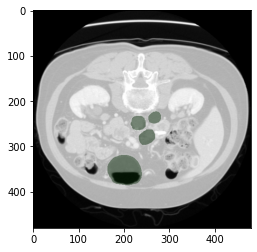

In [20]:

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple


def get_palette(num_cls):
    palette = np.zeros(3 * num_cls, dtype=np.int32)

    for j in range(0, num_cls):
        lab = j
        i = 0

        while lab > 0:
            palette[j*3 + 0] |= (((lab >> 0) & 1) << (7-i))
            palette[j*3 + 1] |= (((lab >> 1) & 1) << (7-i))
            palette[j*3 + 2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3

    return palette.reshape((-1, 3))


def overlay(
    image: np.ndarray,
    mask: np.ndarray,
    color: Tuple[int, int, int] = (255, 0, 0),
    alpha: float = 0.5, 
    resize: Tuple[int, int] = (1024, 1024)
) -> np.ndarray:
    """Combines image and its segmentation mask into a single image.
    
    Params:
        image: Training image.
        mask: Segmentation mask.
        color: Color for segmentation mask rendering.
        alpha: Segmentation mask's transparency.
        resize: If provided, both image and its mask are resized before blending them together.
    
    Returns:
        image_combined: The combined image.
        
    """
    color = np.asarray(color).reshape(3, 1, 1)
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()
    
    if resize is not None:
        image = cv.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv.resize(image_overlay.transpose(1, 2, 0), resize)
    
    image_combined = cv.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    
    return image_combined


image = cv.imread(img_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# image = np.transpose(image, [2,0,1]) * 2

mask = cv.imread(mask_path)[:, :, 0].astype(np.int32)
palette = get_palette(np.max(mask) + 1)
rgb_mask = palette[mask.astype(np.uint8)]

# result = overlay(image, mask)

alpha=0.5
result = image.copy()
mask_region = (mask > 0).astype(np.uint8)
result = result * (1 - mask_region[:, :, np.newaxis]) + \
            (1 - alpha) * mask_region[:, :, np.newaxis] * result + \
            alpha * rgb_mask
result = result.astype(np.uint8)

plt.imshow(result)
